<a href="https://colab.research.google.com/github/Sjmuita/Sentinel-Real-Time-Weapon-Detection-and-Facial-Recognition-System-/blob/main/Sentinel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup Environment**

First, ensure you have cloned the YOLOv5 repository and installed the required dependencies:

In [ ]:
# Install necessary dependencies
!pip install -U torch torchvision torchaudio
!pip install PyYAML
!pip install seaborn

# Clone the YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

# Install YOLOv5 dependencies
!pip install -r requirements.txt



  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 

# **Importing Necessary Libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model


# **Upload Your Dataset to Google Drive:**

You can use Google Drive to store your dataset and then mount your Google Drive to access the files from Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Create the dataset.yaml File:**

Create the configuration file directly in Google Colab.

In [ ]:
# Create dataset.yaml file
dataset_yaml = """
train: /content/drive/MyDrive/Weapons/weapon_detection/train/images
val: /content/drive/MyDrive/Weapons/weapon_detection/val/images

nc: 6  # number of classes
names: ['class1', 'class2', 'class3', 'class4', 'class5', 'class6']  # class names
"""

with open('dataset.yaml', 'w') as file:
    file.write(dataset_yaml)


Verify the File Path

In [ ]:
import os

file_path = '/content/yolov5/dataset.yaml'
if os.path.exists(file_path):
    print("File found:", file_path)
else:
    print("File not found:", file_path)


File found: /content/yolov5/dataset.yaml


yolov5 directory path

In [ ]:
%cd /content/yolov5


/content/yolov5


# **Verify the Dataset Structure:**



Metadata Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   imagefile  714 non-null    object
 1   labelfile  714 non-null    object
 2   target     714 non-null    int64 
 3   train_id   714 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 22.4+ KB
None

Metadata Description:
           target   train_id
count  714.000000  714.00000
mean     4.184874    0.79972
std      2.604236    0.40049
min      0.000000    0.00000
25%      2.000000    1.00000
50%      4.000000    1.00000
75%      6.000000    1.00000
max      8.000000    1.00000

Training Dataset Statistics:
            Height        Width
count   571.000000   571.000000
mean    929.775832  1303.500876
std     737.066591   953.652059
min     140.000000   220.000000
25%     441.500000   720.000000
50%     720.000000  1200.000000
75%    1080.000000  1500.000000
max    5792.000000  7

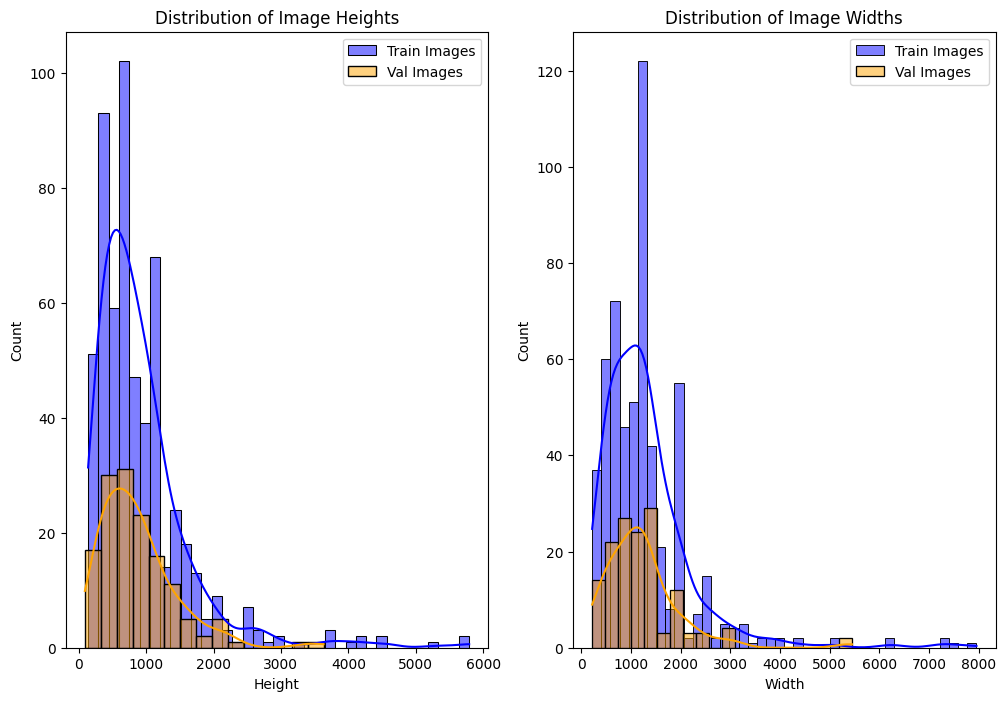

Sample Images from Training Set:


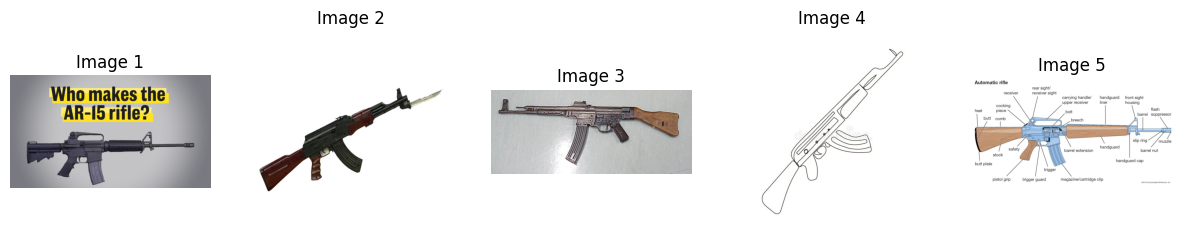

Sample Images from Validation Set:


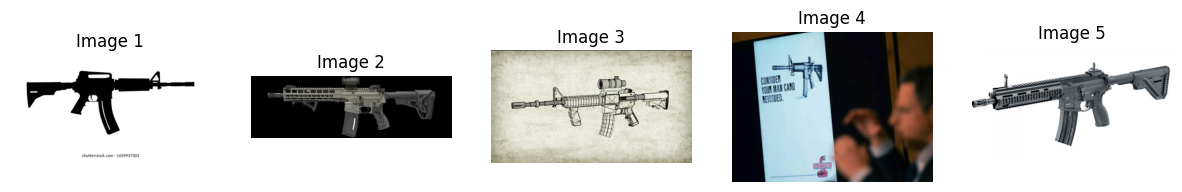

In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to the images and metadata
train_image_dir = '/content/drive/MyDrive/Weapons/weapon_detection/train/images'
val_image_dir = '/content/drive/MyDrive/Weapons/weapon_detection/val/images'
metadata_path = '/content/drive/MyDrive/Weapons/metadata.csv'

# Helper function to read and return image size
def get_image_size(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        return image.shape[:2]  # returns (height, width)
    else:
        return (None, None)

# List all image files in a directory
def list_image_files(image_dir):
    return [os.path.join(image_dir, f) for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Collect image sizes for a list of images
def collect_image_sizes(image_files):
    image_sizes = [get_image_size(img) for img in image_files if get_image_size(img)[0] is not None]
    return zip(*image_sizes)

# Load and analyze metadata
metadata_df = pd.read_csv(metadata_path)
print("Metadata Info:")
print(metadata_df.info())

print("\nMetadata Description:")
print(metadata_df.describe())

# Load and analyze images
train_image_files = list_image_files(train_image_dir)
val_image_files = list_image_files(val_image_dir)

train_heights, train_widths = collect_image_sizes(train_image_files)
val_heights, val_widths = collect_image_sizes(val_image_files)

# Create DataFrames for analysis
train_df = pd.DataFrame({
    'Filename': [os.path.basename(img) for img in train_image_files if get_image_size(img)[0] is not None],
    'Height': train_heights,
    'Width': train_widths
})

val_df = pd.DataFrame({
    'Filename': [os.path.basename(img) for img in val_image_files if get_image_size(img)[0] is not None],
    'Height': val_heights,
    'Width': val_widths
})

# Basic statistics
print("\nTraining Dataset Statistics:")
print(train_df.describe())

print("\nValidation Dataset Statistics:")
print(val_df.describe())

# Check for missing values
print("\nTraining Dataset Missing Values:")
print(train_df.isnull().sum())

print("\nValidation Dataset Missing Values:")
print(val_df.isnull().sum())

# Plot the distribution of image heights and widths
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.histplot(train_df['Height'], kde=True, color='blue', label='Train Images')
sns.histplot(val_df['Height'], kde=True, color='orange', label='Val Images')
plt.title('Distribution of Image Heights')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(train_df['Width'], kde=True, color='blue', label='Train Images')
sns.histplot(val_df['Width'], kde=True, color='orange', label='Val Images')
plt.title('Distribution of Image Widths')
plt.legend()

plt.show()

# Display sample images
def display_sample_images(image_files, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(image_files))):
        img = cv2.imread(image_files[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_rgb)
        plt.title(f'Image {i+1}')
        plt.axis('off')
    plt.show()

# Display sample images from the training set
print("Sample Images from Training Set:")
display_sample_images(train_image_files)

# Display sample images from the validation set
print("Sample Images from Validation Set:")
display_sample_images(val_image_files)


# **Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

# Apply these layers to the same image
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')


# **Run the YOLOv5 Training Script:**

Finally, run the training script using the paths to your dataset stored in Google Drive.

In [ ]:
!python train.py --img 640 --batch 16 --epochs 100 --data dataset.yaml --weights yolov5s.pt


2024-08-04 15:54:23.590283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 15:54:23.648129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 15:54:23.667335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, o

In [ ]:
!python train.py --img 640 --batch 16 --epochs 10 --data dataset.yaml --weights yolov5s.pt


2024-08-04 16:27:22.788331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 16:27:22.813958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 16:27:22.822514: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, op

# **Training the YOLOv5 Model**

Use the following Python script to train the model:

In [ ]:
import os

file_path = '/content/yolov5/dataset.yaml'
if os.path.exists(file_path):
    print("File found:", file_path)
else:
    print("File not found:", file_path)


File found: /content/yolov5/dataset.yaml


In [ ]:
import torch
from yolov5 import train

# Set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Training parameters
img_size = 640
batch_size = 16
epochs = 10
data = '/content/yolov5/dataset.yaml'
weights = 'yolov5s.pt'  # Starting from pre-trained model

# Training command
train.run(imgsz=img_size, batch_size=batch_size, epochs=epochs, data=data, weights=weights, device=device)


train: weights=yolov5s.pt, cfg=, data=/content/yolov5/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=cpu, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-350-g6096750f Python-3.10.12 torch-2.4.0+cu121 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0,

# *Check Model Initialization: *

When loading the YOLOv5 model, ensure that you're correctly specifying the path to the best.pt file. Here's an example of how you might initialize the model:

In [ ]:
import torch

# Example initialization
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True, force_reload=True)


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-339-g150a1a31 Python-3.10.12 torch-2.3.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


# **Plot Learning Curves**

In [ ]:
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset
)


NameError: name 'model' is not defined

In [ ]:
# Training the model
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset
)

# Plotting the training and validation accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


NameError: name 'history' is not defined

# **Fine-tuning**

In [ ]:
# Unfreeze the top layers of the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.summary()


# **Continue Training the Model**

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)


# **Plot Learning Curves After Fine-tuning**

In [ ]:
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


# **Evaluation and Prediction**

In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(validation_dataset)
print('Validation accuracy:', accuracy)

# Retrieve a batch of images from the validation set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i].numpy()])
    plt.axis("off")


# **Application**

In [ ]:
import cv2
import os
import zipfile
import time
import base64
import csv
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
import torch
from PIL import Image

# Define paths
zip_file_path = r'C:\Users\Admin\Downloads\archive (9).zip'
extract_dir = r'C:\Users\Admin\Downloads\haarcascade'
csv_file_path = r'C:\Users\Admin\Downloads\alerts_log.csv'

# Extract Haar Cascade XML file
def unzip_cascade(zip_path, extract_to):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f'Haar Cascade XML extracted to {extract_to}')
    except Exception as e:
        print(f"Error extracting Haar Cascade XML: {e}")

unzip_cascade(zip_file_path, extract_dir)

def load_face_cascade(cascade_path):
    try:
        face_cascade = cv2.CascadeClassifier(cascade_path)
        if face_cascade.empty():
            raise ValueError("Failed to load Haar Cascade.")
        print(f"Face cascade model loaded successfully from {cascade_path}")
        return face_cascade
    except Exception as e:
        print(f"Failed to load face cascade: {e}")
        return None

# Define the path to the Haar Cascade XML file
haar_cascade_file = os.path.join(extract_dir, 'haarcascade_frontalface_default.xml')
face_cascade = load_face_cascade(haar_cascade_file)

def authenticate_gmail():
    SCOPES = ['https://www.googleapis.com/auth/gmail.send']
    creds = None
    try:
        if os.path.exists('token.json'):
            creds = Credentials.from_authorized_user_file('token.json', SCOPES)
        if not creds or not creds.valid:
            if creds and creds.expired and creds.refresh_token:
                creds.refresh(Request())
            else:
                flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
                creds = flow.run_local_server(port=0)
            with open('token.json', 'w') as token:
                token.write(creds.to_json())
        return creds
    except Exception as e:
        print(f"Error during Gmail authentication: {e}")
        return None

def send_alert(subject, body, to_email):
    try:
        creds = authenticate_gmail()
        if creds is None:
            print("Failed to authenticate Gmail.")
            return

        service = build('gmail', 'v1', credentials=creds)

        message = MIMEMultipart()
        message['From'] = 'jessysteve251@gmail.com'
        message['To'] = to_email
        message['Subject'] = subject
        message.attach(MIMEText(body, 'plain'))

        raw_message = base64.urlsafe_b64encode(message.as_bytes()).decode()
        send_message = service.users().messages().send(userId='me', body={'raw': raw_message}).execute()
        print(f"Message sent successfully! Message ID: {send_message['id']}")
    except Exception as e:
        print(f"An error occurred while sending the alert: {e}")

def load_yolov5_model(model_path):
    try:
        # Load the YOLOv5 model with the trained weights
        model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)
        model.eval()
        print(f"YOLOv5 model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Failed to load YOLOv5 model: {e}")
        return None

# Define the path to the YOLOv5 model
yolov5_model_path = r'C:\Users\Admin\Downloads\yolov5\trained_model.pt'  # Ensure this is the path to your trained model
yolov5_model = load_yolov5_model(yolov5_model_path)

def log_alert_to_csv(subject, body, alert_type, location, timestamp):
    try:
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([timestamp, alert_type, body, location])
        print(f"Alert logged to CSV file.")
    except Exception as e:
        print(f"Error logging alert to CSV: {e}")

def detect_objects_from_webcam(model, face_cascade, duration):
    cap = cv2.VideoCapture(0)  # Use 0 for the default webcam
    if not cap.isOpened():
        print("Failed to open webcam.")
        return

    start_time = time.time()  # Record the start time
    alert_triggered_face = False
    alert_triggered_weapon = False
    location = "Static Location"  # Placeholder for actual location

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame.")
            break

        # Convert frame to PIL image for YOLOv5
        pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        results = model(pil_img)

        # Convert to grayscale for face detection
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        if len(faces) > 0:
            print(f"Detected {len(faces)} face(s)!")

        # Draw rectangles around detected faces
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Process YOLOv5 results
        for detection in results.xyxy[0]:  # Iterate over detections
            x1, y1, x2, y2, conf, cls = detection
            label = model.names[int(cls)]
            timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
            print(f"Detected: {label} with confidence {conf:.2f}")  # Print detected labels and confidences

            if label == 'weapon':
                if not alert_triggered_weapon:
                    print("Weapon detected!")
                    subject = "Alert: Weapon Detected"
                    body = "A weapon has been detected in the video stream."
                    to_email = 'jessysteve251@gmail.com'
                    send_alert(subject, body, to_email)
                    log_alert_to_csv(subject, body, 'Weapon', location, timestamp)
                    alert_triggered_weapon = True

            if conf > 0.5:
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                cv2.putText(frame, f'{label} {conf:.2f}', (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Display the result
        cv2.imshow('Real-time Detection', frame)

        try:
            if len(faces) >= 2 and not alert_triggered_face:
                print(f"Two or more faces detected ({len(faces)} faces)!")
                subject = "Alert: Multiple Faces Detected"
                body = f"Two or more faces have been detected in the video stream ({len(faces)} faces detected)."
                to_email = 'jessysteve251@gmail.com'
                send_alert(subject, body, to_email)
                timestamp = time.strftime("%Y-%m-%d %H:%M:%S")
                log_alert_to_csv(subject, body, 'Face', location, timestamp)
                alert_triggered_face = True

            if len(faces) < 2:
                alert_triggered_face = False

            if len(results.xyxy[0]) == 0:  # Reset weapon alert if no weapon detected
                alert_triggered_weapon = False

        except Exception as e:
            print(f"Error during detection: {e}")

        # Check if the duration has passed
        elapsed_time = time.time() - start_time
        if elapsed_time > duration:
            print("Duration elapsed. Exiting...")
            break

        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Quitting...")
            break

    cap.release()
    cv2.destroyAllWindows()

# Run real-time detection for a specified duration (e.g., 60 seconds)
detect_objects_from_webcam(yolov5_model, face_cascade, duration=20)
